# F-μ-F

The interaction between a muon and Fluorine atoms in solids is a simple yet interesting phenomemon for a variety of reasons.
From a theoretical point of view, the description of the spin relaxation of the muon given a nice realisation of a decoherence process (Wilkinson and Blundell [2020](https://doi.org/10.1103/PhysRevLett.125.087201])). μSR makes it easy to study this phenomenon in detail, distinguishing between the "system", the F-mu-F, and the more distant nuclear spins that act as source of decoherence.

From a practical point of view, F-μ-F states can be used to identify muon sites (Potočnik et al. [2010](https://doi.org/10.1103/PhysRevB.81.214420)) or, possibly, to characterize a compound, to some extent (Wilkinson et al. [2021](https://doi.org/10.1103/PhysRevB.104.L220409)).
More generally, an experimental signal showing coherent oscillations in the muon polarization function is expected whenever the muon interacts more strongly with a limited set of nuclei with large nuclear moments (Bonfà et al. [2022](https://doi.org/10.1103/PhysRevLett.129.097205)).

The Hamiltonian describing the interaction between one muon and two nuclei is given by

$$
\hat{\mathcal{H}} = \sum_{i=1,2} \frac{\mu_0 \gamma_i \gamma_\mu}{4 \pi \hbar |\mathbf{r}_{i,\mu}|^3} \Big[ \mathbf{s}_i \mathbf{\cdot} \mathbf{s}_\mu - 3 \big(\mathbf{s}_i \mathbf{\cdot}\mathbf{\hat{r}}_{i,\mu} \big)\big(\mathbf{s}_\mu \mathbf{\cdot}\mathbf{\hat{r}}_{i,\mu} \big) \Big]
$$

Here we will consider the axial geometry which is the most common for F-μ-F states. The analytical solution for the muon polarization function, provided by Brewer et al. [1986](https://doi.org/10.1103/PhysRevB.33.7813), is known as the F-μ-F polarization function:
 
$$
G(t)=\frac{1}{6}\left[3+\cos(\sqrt{3} \omega_\text{D} t)+\left(1-\frac{1}{\sqrt{3}}\right)\cos(\frac{3-\sqrt{3}}{2}\omega_\text{D} t)+\left(1+\frac{1}{\sqrt{3}}\right)\cos(\frac{3+\sqrt{3}}{2}\omega_\text{D} t)\right]
$$

In the next steps we are going to reproduce this result with a computer simulation, but we will also evaluate the effect of the more distant nuclei.



In [1]:
# We define the F-mu-F function in Python below
def plot_brewer(interval,r):
    from numpy import cos, sin, sqrt
    omegad = (mu_0*NS.gammas['mu']*NS.gammas['F']*(hbar))
    omegad /=(4*np.pi*((r)**3))
    
    tomegad=interval*omegad
    y = (1./6.)*(3+cos(sqrt(3)*tomegad)+ \
                (1-1/sqrt(3))*cos(((3-sqrt(3))/2)*tomegad)+ \
                (1+1/sqrt(3))*cos(((3+sqrt(3))/2)*tomegad))
    return y

## Setup

We will first import the `undi` package. In what follows the code has already been installed for you. In general you can install it with

```bash
pip install undi
```

or using

```
%pip install undi
```

in jupyter notebook/lab.

In [2]:
# Importing stuff...
from undi import MuonNuclearInteraction # the core UNDI class
import matplotlib.pyplot as plt         # for plotting
import numpy as np                      # for arrays

## Geometry in the UNDI code

Within UNDI, the initial spin polarization and the position of detectors are assumed to be along $z$. As a consequence, from the definizion of polarization function

$$
P_{i_\mu,d_p}(t)= \frac{\langle S_\mu (t) \rangle}{S_\mu(0)}\cdot \mathbf{d}_p = \frac{1}{2} \text{Tr} \left\{ \rho_{sys} (\mathbf{i}_\mu \cdot \boldsymbol{\sigma}) \left[ \boldsymbol{\sigma}(t) \cdot \mathbf{d}_p \right] \right\}
$$


where $\mathbf{i}_\mu=\mathbf{S}_\mu(0) / {S}_\mu(0)$ is the initial muon polarisation vector and $\mathbf{d}_p$ is the direction used for projection (which is defined by the geometry of the experiment). In the righ-hand side, $\sigma$ is the Pauli operator for the muon spin and $\rho_{sys}$ is the density matrix of the hosting system, taken to be $\rho_{sys}\sim \mathcal I/N$.

UNDI computes $P_{i_z,d_z}(t) := P_Z(t)$. 


<div>
<img src="imgs/geometry.png" width="150px" />
</div>

(image from [Relaxation functions by P. Dalmas de Réotier](https://www.isis.stfc.ac.uk/Gallery/Relaxation%20Functions%201%20and%202%20-%20Pierre%20Dalmas.pdf))

Other geometries are possible, but are out of the scope of the present tutorial (and require some simple coding).

## The F-μ-F depolarization function

Let us consider a linear F-μ-F molecule of total length $2r$ aligned along $x$. The separation between the muon and the nearest neighboring F nuclei is predicted to be $r=1.15$ Ang. from DFT based simulations. We will place the muon at the origin of our Cartesian coordinate system. Remember that UNDI uses SI units for *all* input quantities. A few constants are defined below for convenience.

The input for UNDI is provided as a simple list of dictionaries providing the details for each nucleus. There are only two mandatory inputs: `Position` and `Label`. The former is the position of the nucleus in Cartesian space, the latter identifies the nuclus. It can be both a chemical symbol or a precise isotope. If no isotope is specified, UNDI will select **the most abundant one**. For a list of available options see (Bonfà et al [2020](https://doi.org/10.1016/j.cpc.2020.107719)).

In [3]:
angtom=1.0e-10 # m
h=6.6260693e-34 # Js
hbar=h/(2*np.pi) # Js
mu_0=(4e-7)*np.pi # Tm A-1

# This is a linear F-mu-F along x. The distance has been obtained from DFT simulations
r=1.15 * angtom
atoms = [
            {'Position': np.array([-r, 0., 0.]),
            'Label': 'F'},
            
            {'Position': np.array([0., 0., 0 ]),
            'Label': 'mu'},
            
            {'Position': np.array([r, 0., 0.]),
            'Label': 'F'}
        ]

We pass the input to the main class which can later be used to perform all simulations based on the geometry specified in the `atoms` variable.

## Computation

In the next cells we compute the polarization for a 10 μs time window rotating the F-μ-F "molecule" along different directions. This is required to obtain the powder average and compare the result with the experiment. 
For more details on the powder average see for example [John Wilkinson's PhD thesis](https://ora.ox.ac.uk/objects/uuid:b7c1fc6c-70f8-44f4-a7e0-6893ea7a6f61/files/dnc580n113).

The method `NS.polarization` performs the following tasks:

1. builds the Hamiltonian according to the input defined in `atoms`,
2. finds the eigenstates of the Hamiltonian and computes the time evolution operator
3. computes the projection of the time evolved muon spin along the $z$ direction.

The muon spin in initially polarized along $z$ and this function provides the polarization function along the $z$ axis.
The option `cutoff` can be used to set the maximum lenght for the dipolar interactions included in the simulation.
In our case we set it to 1.2 Ang. since we want to avoid the internuclear F-F interaction.

Further details are provided as comments below.

In [4]:
# Time values, in seconds
time = np.linspace(0, 10e-6, 200)

# Define main class
NS = MuonNuclearInteraction(atoms, log_level='info')

# This function places the muon at the origin and rotates the positions defined in the
# input data by the angle defined by the vector given in input ([0,0,1] in this case) and z.
# [0,0,1] is actually parallel to z, so the angle is 0 deg. and no rotation is performed.
NS.translate_rotate_sample_vec([0,0,1])
# there are other functions to perform rotations based on Euler angles or the user can just provide
# properly rotated positions in the `atoms` dictionary.

# cutoff the dipolar interaction in order to avoid F-F term
signal_FmuF_z = NS.polarization(time, cutoff=1.2 * angtom)

In [5]:
NS = MuonNuclearInteraction(atoms, log_level='info')

# This time we rotate our sample by 90 deg with an axis parallel to x.
NS.translate_rotate_sample_vec([0,1,0])
signal_FmuF_y = NS.polarization(time, cutoff=1.2 * angtom)

In [6]:
NS = MuonNuclearInteraction(atoms, log_level='info')
# Finallly again a rotation by 90 deg with an axis parallel to y.
NS.translate_rotate_sample_vec([1,0,0])
signal_FmuF_x = NS.polarization(time, cutoff=1.2 * angtom)

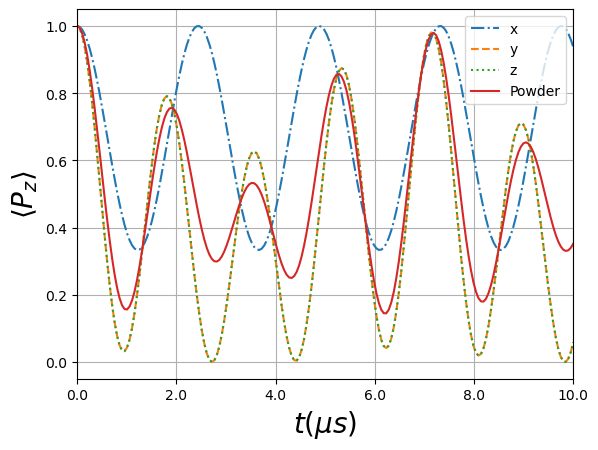

In [7]:
# Here we only plot the results

fig, axes = plt.subplots(1,1)
axes.plot(time, signal_FmuF_x, label='x', linestyle='-.')
axes.plot(time, signal_FmuF_y, label='y', linestyle='--')
axes.plot(time, signal_FmuF_z, label='z', linestyle=':')

# In zero field, the powder average is just obtained by summing the results for the three directions devided by 3.
axes.plot(time, (signal_FmuF_x+signal_FmuF_y+signal_FmuF_z)/3, label='Powder', linestyle='-')
axes.legend()
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'$\left<P_z\right>$', fontsize=20)
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticks(ticks*10.**-6)
axes.set_xticklabels(ticks)
axes.set_xlim([0,10.**-5])
axes.grid()
plt.show()

## Comparison

We will now compare the computational result with the analytical solution. We do expect a perfect match that is indeed observed.

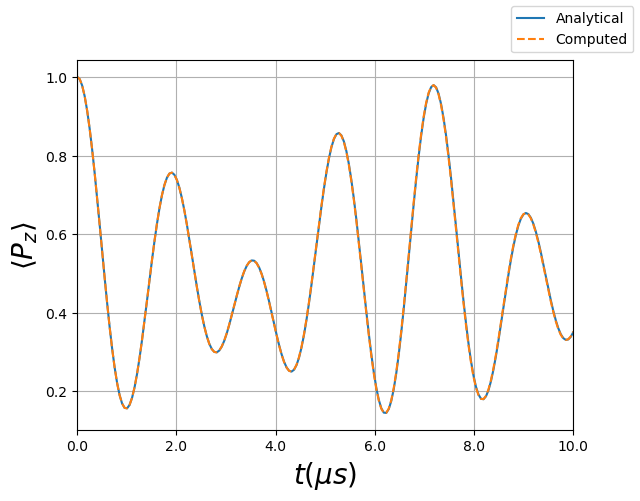

In [8]:
fig, axes = plt.subplots(1,1)
axes.plot(time, plot_brewer(time, r), label=r'Analytical', linestyle='-')
axes.plot(time, (signal_FmuF_x+signal_FmuF_y+signal_FmuF_z)/3, label='Computed', linestyle='--')
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'$\left<P_z\right>$', fontsize=20);
axes.grid()
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticks(ticks*10.**-6)
axes.set_xticklabels(ticks)
axes.set_xlim([0,10.**-5])
fig.legend()
plt.show()

### One step beyond, adding internuclear dipolar interactions

At this stage we can move one step farward and add the dipolar interaction between the F nuclei. This will only slightly affect our estimate since the nuclear moment of F nuclei is 3 times smaller than the one of the muon and they are 2.3 Ang. apart from each other.

The result is easily obtained by just removing the `cutoff` option from the previous set of instructions.

It should be noted that this addition does not increase the dimension of the Hilbert space and is therefore almost free.

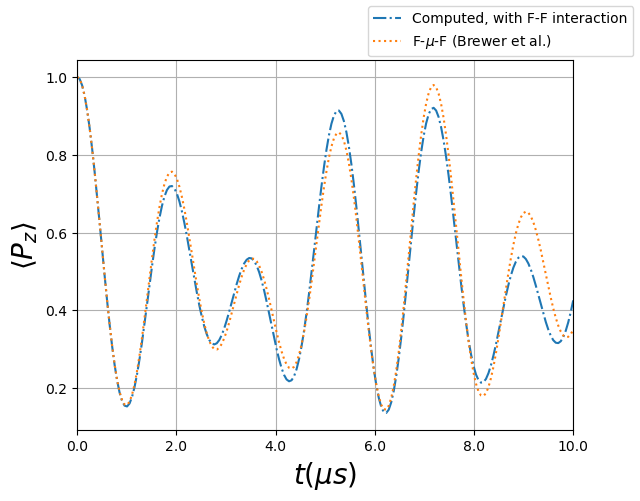

In [9]:

# no cutoff this time
NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([0,0,1])
signal_FmuF_with_Fdip = NS.polarization(time)

NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([0,1,0])
signal_FmuF_with_Fdip += NS.polarization(time)

NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([1,0,0])
signal_FmuF_with_Fdip += NS.polarization(time)

signal_FmuF_with_Fdip /= 3.

####################
# Plot the results #
####################
fig, axes = plt.subplots(1,1)
axes.plot(time, signal_FmuF_with_Fdip, label='Computed, with F-F interaction', linestyle='-.')

# Generate and plot analytical version for comparison
def plot_brewer(interval,r):
    from numpy import cos, sin, sqrt
    omegad = (mu_0*NS.gammas['mu']*NS.gammas['F']*(hbar))
    omegad /=(4*np.pi*((r)**3))
    
    tomegad=interval*omegad
    y = (1./6.)*(3+cos(sqrt(3)*tomegad)+ \
                (1-1/sqrt(3))*cos(((3-sqrt(3))/2)*tomegad)+ \
                (1+1/sqrt(3))*cos(((3+sqrt(3))/2)*tomegad))#+0.05*(exp(-x/2.5))**1.5
    return y

axes.plot(time, plot_brewer(time, r), label=r'F-$\mu$-F (Brewer et al.)', linestyle=':')

ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticks(ticks*10.**-6)
axes.set_xticklabels(ticks)
axes.set_xlim([0,10.**-5])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'$\left<P_z\right>$', fontsize=20);
axes.grid()
fig.legend()
plt.show()

## Decoherence

Let's include the more distant Li nuclei in our simulation. The code will automatically select the most abundant isotope, <sup>7</sup>Li, which has spin I=3/2 (this implies a small approximation since 7.6% of Li nuclei have spin 1).
The nearest neighboring Li atoms are shown below

![](imgs/mufli.png)

The new nuclei must be added to the input, as done below.

In [10]:
# This is a linear F-mu-F along z
r_F=1.17 * angtom
r_Li=1.84 * angtom
atoms = [
            {'Position': np.array([-r_F, 0., 0.]),
            'Label': 'F'},

            {'Position': np.array([0, -r_Li, 0.]),
            'Label': 'Li'},
    
            {'Position': np.array([0., 0., 0]),
            'Label': 'mu'},
            
            {'Position': np.array([r_F, 0., 0 ]),
            'Label': 'F'},

            {'Position': np.array([0, r_Li, 0.]),
            'Label': 'Li'},
        ]

In [11]:
# no cutoff this time
NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([0,0,1])
signal_FmuF_with_Li = NS.polarization(time)

NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([0,1,0])
signal_FmuF_with_Li += NS.polarization(time)

NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([1,0,0])
signal_FmuF_with_Li += NS.polarization(time)

signal_FmuF_with_Li /= 3.

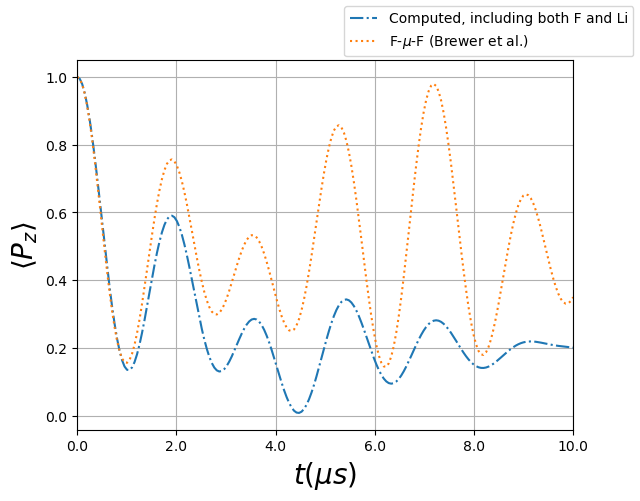

In [12]:

fig, axes = plt.subplots(1,1)
axes.plot(time, signal_FmuF_with_Li, label='Computed, including both F and Li', linestyle='-.')

axes.plot(time, plot_brewer(time, r), label=r'F-$\mu$-F (Brewer et al.)', linestyle=':')

ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticks(ticks*10.**-6)
axes.set_xticklabels(ticks)
axes.set_xlim([0,10.**-5])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'$\left<P_z\right>$', fontsize=20);
axes.grid()
fig.legend()
plt.show()

## Advanced

Li has a quadrupolar moment different from zero. The positive muon will induce an electric field gradient at the Li nuclei and this will in turn slightly influence the result. We define the quadrupolar component as

$$
\mathcal{H}_{\mathrm{Q}, i} = \hbar \omega_{\mathrm{E}}\left[\left(\hat{\mathbf{n}} \cdot I_{i}\right)\left(\hat{\mathbf{n}} \cdot I_{i}\right)-\frac{I_{i}^{2}}{3}\right]
$$

where $\hat{\mathbf{n}}$ is the unit vector joining the muon and the $i$-th nucleus and the value for $\omega_{\mathrm{E}}$ is specified with the input `OmegaQmu` (a more general description can be done with `EFGTensor`). The value for $\omega_{\mathrm{E}}$ is selected to show the expected effect. It's actual value (which depends on the perturbation introduced by the muon) can be estimated from first principles calculations.

In [13]:
atoms = [
            {'Position': np.array([-r_F, 0., 0.]),
            'Label': 'F'},

            {'Position': np.array([0, -r_Li, 0.]),
            'Label': 'Li',
            'OmegaQmu': 3e5},
    
            {'Position': np.array([0., 0., 0]),
            'Label': 'mu'},
            
            {'Position': np.array([r_F, 0., 0 ]),
            'Label': 'F'},

            {'Position': np.array([0, r_Li, 0.]),
            'Label': 'Li',
            'OmegaQmu': 3e5},
        ]

In [14]:
# no cutoff this time
NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([0,0,1])
signal_FmuF_with_EFG = NS.polarization(time)

NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([0,1,0])
signal_FmuF_with_EFG += NS.polarization(time)

NS = MuonNuclearInteraction(atoms, log_level='info')
NS.translate_rotate_sample_vec([1,0,0])
signal_FmuF_with_EFG += NS.polarization(time)

signal_FmuF_with_EFG /= 3. # powder average.

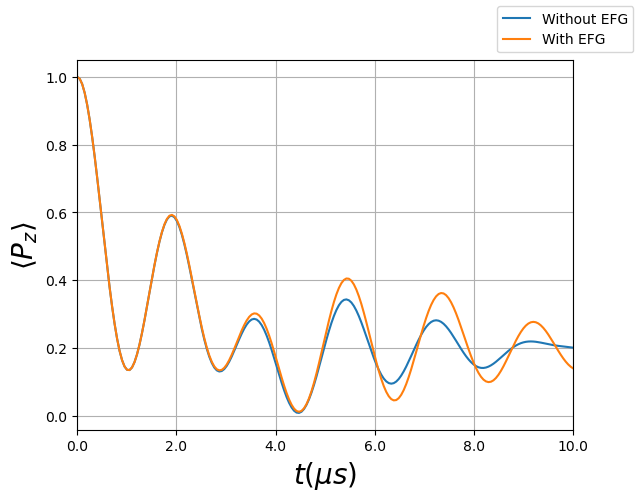

In [15]:
fig, axes = plt.subplots(1,1)
axes.plot(time, signal_FmuF_with_Li, label='Without EFG', linestyle='-')
axes.plot(time, signal_FmuF_with_EFG, label='With EFG', linestyle='-')

ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticks(ticks*10.**-6)
axes.set_xticklabels(ticks)
axes.set_xlim([0,10.**-5])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'$\left<P_z\right>$', fontsize=20);
axes.grid()
fig.legend()
plt.show()